In [1]:
# Cell 1: Imports and Configuration
import torch
import os
import torch.nn.functional as F
from datasets import load_dataset, Dataset
from PIL import Image
from transformers import (
    AutoProcessor,
    AutoModel,
    TrainingArguments,
    Trainer
)
from peft import LoraConfig, get_peft_model
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import requests
from io import BytesIO
from tqdm import tqdm
import pickle
from pathlib import Path

# Configuration
CONFIG = {
    'MODEL_ID': "google/siglip-base-patch16-224",
    'OUTPUT_DIR': "./siglip-scin-lora",
    'DATA_DIR': "./data/scin_cache",  # Local cache directory
    'BATCH_SIZE': 16,
    'LEARNING_RATE': 1e-4,
    'LORA_RANK': 16,
    'LORA_ALPHA': 16,
    'MAX_STEPS': 500,
    'LOSS_TYPE': "sigmoid",  # or "contrastive"
    'N_VAL_SAMPLES': 1000,
    'N_TRAIN_SAMPLES': 5000,  # Set to None to use all available
}

# Create directories
os.makedirs(CONFIG['OUTPUT_DIR'], exist_ok=True)
os.makedirs(CONFIG['DATA_DIR'], exist_ok=True)

# Device setup
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")
print(f"Configuration: {CONFIG}")

/home/vinoo/projects/health-kiosk/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Configuration: {'MODEL_ID': 'google/siglip-base-patch16-224', 'OUTPUT_DIR': './siglip-scin-lora', 'DATA_DIR': './data/scin_cache', 'BATCH_SIZE': 16, 'LEARNING_RATE': 0.0001, 'LORA_RANK': 16, 'LORA_ALPHA': 16, 'MAX_STEPS': 500, 'LOSS_TYPE': 'sigmoid', 'N_VAL_SAMPLES': 1000, 'N_TRAIN_SAMPLES': 5000}


In [2]:
# Cell 2: Data Loading and Caching Functions

def download_and_cache_dataset(n_train=5000, n_val=1000, force_redownload=False):
    """
    Download dataset from HuggingFace and cache locally.
    
    Args:
        n_train: Number of training samples (None for all)
        n_val: Number of validation samples
        force_redownload: Force redownload even if cache exists
    
    Returns:
        tuple: (train_data_list, val_data_list)
    """
    train_cache = Path(CONFIG['DATA_DIR']) / f"train_{n_train}.pkl"
    val_cache = Path(CONFIG['DATA_DIR']) / f"val_{n_val}.pkl"
    
    # Check if cache exists
    if not force_redownload and train_cache.exists() and val_cache.exists():
        print(f"Loading cached dataset from {CONFIG['DATA_DIR']}")
        with open(train_cache, 'rb') as f:
            train_data = pickle.load(f)
        with open(val_cache, 'rb') as f:
            val_data = pickle.load(f)
        print(f"Loaded {len(train_data)} training samples and {len(val_data)} validation samples from cache")
        return train_data, val_data
    
    # Download from HuggingFace
    print("Downloading dataset from HuggingFace...")
    try:
        base_iterable = load_dataset("google/scin", split="train", streaming=True)
    except Exception as e:
        print(f"Failed to load dataset. Error: {e}")
        print("Please ensure you have an internet connection and have accepted 'google/scin' terms if any.")
        raise
    
    image_columns = ["image_1_path", "image_2_path", "image_3_path"]
    
    # Load validation data
    print(f"Loading {n_val} validation samples...")
    val_data = []
    for item in tqdm(base_iterable.take(n_val), total=n_val, desc="Loading val samples"):
        text = item.get("related_category")
        if not text or not isinstance(text, str):
            continue
        
        for img_col in image_columns:
            image = item.get(img_col)
            if image and isinstance(image, Image.Image):
                try:
                    val_data.append({"image": image.convert("RGB"), "text": text})
                    break
                except Exception as e:
                    print(f"Error converting image, skipping: {e}")
                    break
    
    # Load training data
    train_iterable = base_iterable.skip(n_val)
    print(f"Loading training samples (max: {n_train if n_train else 'all'})...")
    train_data = []
    
    if n_train:
        iterator = tqdm(train_iterable.take(n_train), total=n_train, desc="Loading train samples")
    else:
        iterator = tqdm(train_iterable, desc="Loading train samples")
    
    for item in iterator:
        text = item.get("related_category")
        if not text or not isinstance(text, str):
            continue
        
        for img_col in image_columns:
            image = item.get(img_col)
            if image and isinstance(image, Image.Image):
                try:
                    train_data.append({"image": image.convert("RGB"), "text": text})
                    break
                except Exception as e:
                    print(f"Error converting image, skipping: {e}")
                    break
        
        if n_train and len(train_data) >= n_train:
            break
    
    # Save to cache
    print(f"Saving {len(train_data)} training samples to cache...")
    with open(train_cache, 'wb') as f:
        pickle.dump(train_data, f)
    
    print(f"Saving {len(val_data)} validation samples to cache...")
    with open(val_cache, 'wb') as f:
        pickle.dump(val_data, f)
    
    print(f"Dataset cached to {CONFIG['DATA_DIR']}")
    return train_data, val_data


def clear_cache():
    """Clear all cached dataset files."""
    cache_dir = Path(CONFIG['DATA_DIR'])
    if cache_dir.exists():
        for file in cache_dir.glob("*.pkl"):
            file.unlink()
            print(f"Deleted {file}")
        print("Cache cleared")
    else:
        print("No cache to clear")


# Load or download dataset
train_data, val_data = download_and_cache_dataset(
    n_train=CONFIG['N_TRAIN_SAMPLES'],
    n_val=CONFIG['N_VAL_SAMPLES'],
    force_redownload=False  # Set to True to force redownload
)

print(f"\nDataset loaded: {len(train_data)} train, {len(val_data)} val samples")

Some datasets params were ignored: ['splits', 'download_size', 'dataset_size']. Make sure to use only valid params for the dataset builder and to have a up-to-date version of the `datasets` library.


Loading 1000 validation samples...


Loading val samples: 100%|██████████| 1000/1000 [01:06<00:00, 15.03it/s]


Loading training samples (max: 5000)...


Loading train samples:  81%|████████  | 4033/5000 [04:32<01:05, 14.78it/s]


Saving 3032 training samples to cache...
Saving 747 validation samples to cache...
Dataset cached to ./data/scin_cache

Dataset loaded: 3032 train, 747 val samples


In [3]:
# Cell 3: Dataset Classes

class SCIN_Dataset(torch.utils.data.Dataset):
    """
    PyTorch Dataset for SCIN data.
    Works with pre-loaded data lists (from cache or download).
    """
    def __init__(self, data_list):
        print(f"Initializing SCIN_Dataset with {len(data_list)} samples.")
        self.data = data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def collate_fn(batch, processor):
    """
    Data collator with robust error handling.
    """
    processed_images = []
    processed_texts_input_ids = []
    skipped_count = 0

    for i, item in enumerate(batch):
        try:
            if item is None:
                skipped_count += 1
                continue

            img = item.get("image")
            txt = item.get("text")

            # Check for invalid content
            if img is None:
                skipped_count += 1
                continue
            if txt is None or txt.strip() == "":
                skipped_count += 1
                continue

            # Process valid items
            inputs = processor(
                text=[txt],
                images=[img],
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=64
            )

            processed_images.append(inputs["pixel_values"])
            processed_texts_input_ids.append(inputs["input_ids"])

        except Exception as e:
            print(f"WARNING (collate_fn): Skipping item {i} due to error: {e}")
            skipped_count += 1

    if not processed_images:
        if len(batch) > 0:
            print(f"ERROR: Entire batch was skipped! ({skipped_count} items failed)")
        return {}

    try:
        batch_pixel_values = torch.cat(processed_images, dim=0)
        batch_input_ids = torch.cat(processed_texts_input_ids, dim=0)

        return {
            "pixel_values": batch_pixel_values,
            "input_ids": batch_input_ids
        }

    except Exception as e:
        print(f"Error during final batch collation: {e}")
        return {}


# Create datasets
train_dataset = SCIN_Dataset(train_data)
val_dataset = SCIN_Dataset(val_data)

print(f"Datasets created: {len(train_dataset)} train, {len(val_dataset)} val")

Initializing SCIN_Dataset with 3032 samples.
Initializing SCIN_Dataset with 747 samples.
Datasets created: 3032 train, 747 val


In [4]:
# Cell 4: Model Loading

def load_models_and_processor(model_id, device):
    """
    Load processor and two model instances (base and tunable).
    
    Returns:
        tuple: (processor, base_model, model_to_tune)
    """
    print(f"Loading processor and models from: {model_id}")
    
    processor = AutoProcessor.from_pretrained(model_id)
    dtype = torch.float16 if device == "cuda" else torch.float32
    
    # Base model (for baseline evaluation)
    base_model = AutoModel.from_pretrained(
        model_id,
        torch_dtype=dtype
    ).to(device)
    
    # Model to fine-tune
    model_to_tune = AutoModel.from_pretrained(
        model_id,
        torch_dtype=dtype
    )
    
    print("Models and processor loaded successfully")
    return processor, base_model, model_to_tune


def apply_lora(model, rank=16, alpha=16):
    """
    Apply LoRA configuration to a model.
    
    Args:
        model: Base model
        rank: LoRA rank
        alpha: LoRA alpha
    
    Returns:
        Model with LoRA applied
    """
    print(f"Applying LoRA configuration (rank={rank}, alpha={alpha})...")
    
    lora_config = LoraConfig(
        r=rank,
        lora_alpha=alpha,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.1,
        bias="none",
    )
    
    model = get_peft_model(model, lora_config)
    
    print("LoRA applied. Trainable parameters:")
    model.print_trainable_parameters()
    
    return model


# Load models
processor, base_model, model_to_tune = load_models_and_processor(
    CONFIG['MODEL_ID'], 
    device
)

# Apply LoRA to the tunable model
model_to_tune = apply_lora(
    model_to_tune,
    rank=CONFIG['LORA_RANK'],
    alpha=CONFIG['LORA_ALPHA']
)
model_to_tune = model_to_tune.to(device)

print(f"\nModels ready on device: {device}")

Loading processor and models from: google/siglip-base-patch16-224


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!


Models and processor loaded successfully
Applying LoRA configuration (rank=16, alpha=16)...
LoRA applied. Trainable parameters:
trainable params: 1,179,648 || all params: 204,335,618 || trainable%: 0.5773

Models ready on device: cuda


In [72]:
# Cell 5: Metrics and Loss Functions

def compute_metrics(eval_pred):
    """
    Calculate evaluation metrics.
    """
    # Debug: Check what we received
    print(f"\n[compute_metrics] Called with predictions type: {type(eval_pred.predictions)}")
    
    if eval_pred.predictions is None:
        print("[compute_metrics] ERROR: predictions is None!")
        return {
            "accuracy": 0.0,
            "precision": 0.0,
            "recall": 0.0,
            "f1": 0.0,
        }
    
    logits = eval_pred.predictions
    print(f"[compute_metrics] Predictions shape: {logits.shape}")
    print(f"[compute_metrics] Predictions range: [{logits.min():.4f}, {logits.max():.4f}]")
    
    # For contrastive learning, each sample should match itself
    # So we predict which position in the batch is the correct match
    predictions = np.argmax(logits, axis=1)
    true_labels = eval_pred.label_ids
    
    print(f"[compute_metrics] Predicted labels (first 10): {predictions[:10]}")
    print(f"[compute_metrics] True labels (first 10): {true_labels[:10]}")
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='macro', zero_division=0
    )
    acc = accuracy_score(true_labels, predictions)
    
    print(f"[compute_metrics] Computed: acc={acc:.4f}, prec={precision:.4f}, rec={recall:.4f}, f1={f1:.4f}")
    
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


def compute_loss_function(logits_per_image, logits_per_text, loss_type="sigmoid", device="cpu"):
    """
    Compute loss based on loss type.
    
    Args:
        logits_per_image: Image logits
        logits_per_text: Text logits
        loss_type: "contrastive" or "sigmoid"
        device: Device for computation
    
    Returns:
        Combined loss
    """
    batch_size = logits_per_image.shape[0]
    
    if batch_size <= 1:
        return torch.tensor(0.0, device=device, requires_grad=True)
    
    if loss_type == "contrastive":
        labels = torch.arange(batch_size, device=device)
        loss_images = F.cross_entropy(logits_per_image, labels)
        loss_text = F.cross_entropy(logits_per_text, labels)
        loss = (loss_images + loss_text) / 2.0
    elif loss_type == "sigmoid":
        labels = torch.eye(batch_size, device=device)
        loss_images = F.binary_cross_entropy_with_logits(logits_per_image, labels)
        loss_text = F.binary_cross_entropy_with_logits(logits_per_text, labels)
        loss = (loss_images + loss_text) / 2.0
    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")
    
    return loss


print("Metrics and loss functions defined")

Metrics and loss functions defined


In [73]:
# Cell 6: Custom Trainer Class

class CustomTrainer(Trainer):
    """
    Custom Trainer with:
    1. Switchable loss (Contrastive or Sigmoid)
    2. Gradient accumulation for heatmap
    3. Proper evaluation with loss and metrics
    """
    def __init__(self, *args, loss_type="contrastive", **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_type = loss_type
        print(f"CustomTrainer initialized with loss_type: {self.loss_type}")
        
        # Gradient tracking for heatmap
        self.gradient_accumulator = defaultdict(float)
        self.step_count = 0
        
        # Batch stats
        self.successful_batches = 0
        self.skipped_batches_eval = 0

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """Training loss computation."""
        if not inputs or "pixel_values" not in inputs:
            dummy_loss = torch.tensor(0.0, device=model.device, requires_grad=True)
            return (dummy_loss, {}) if return_outputs else dummy_loss

        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text
        
        loss = compute_loss_function(
            logits_per_image,
            logits_per_text,
            loss_type=self.loss_type,
            device=model.device
        )

        return (loss, outputs) if return_outputs else loss

    def training_step(self, model, inputs, num_items_in_batch):
        """Training step with gradient tracking."""
        loss = super().training_step(model, inputs, num_items_in_batch)

        if loss is not None:
            self.step_count += 1
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if param.grad is not None and param.requires_grad:
                        self.gradient_accumulator[name] += param.grad.norm().item()
        return loss

    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        """Evaluation step with loss computation."""
        if not inputs or "pixel_values" not in inputs:
            self.skipped_batches_eval += 1
            return (None, None, None)
        
        with torch.no_grad():
            outputs = model(**inputs)
            
            logits_per_image = outputs.logits_per_image
            logits_per_text = outputs.logits_per_text
            batch_size = logits_per_image.shape[0]
            
            # Check for NaN/Inf
            if torch.isnan(logits_per_image).any() or torch.isinf(logits_per_image).any():
                print("WARNING: NaN or Inf detected in logits during eval.")
                self.skipped_batches_eval += 1
                return (None, None, None)
            
            # Compute loss
            loss = None
            if batch_size <= 1:
                self.skipped_batches_eval += 1
            else:
                loss = compute_loss_function(
                    logits_per_image,
                    logits_per_text,
                    loss_type=self.loss_type,
                    device=model.device
                )
                self.successful_batches += 1
        
        predictions = logits_per_image.cpu()
        # Create a dummy label tensor of the same batch size
        # compute_metrics function seeing the label as 'None' skips calling compute_metrics. 
        # It completely ignores the dummy_labels it's handed. Instead, it just creates its 
        # own correct labels inside the function: true_labels = np.arange(len(predictions))
        dummy_labels = torch.arange(predictions.shape[0], device=predictions.device)
        return (loss, predictions, dummy_labels)

    def _extract_layer_index(self, name_parts):
        """Extract layer index from parameter name."""
        for part in name_parts:
            if part.isdigit():
                return int(part)
        return None

    def _extract_component_name(self, name_parts):
        """Extract component name from parameter name."""
        name_str = ".".join(name_parts)
        if "lora_A" in name_str:
            if "q_proj" in name_str: return "LoRA A (Query)"
            if "v_proj" in name_str: return "LoRA A (Value)"
        elif "lora_B" in name_str:
            if "q_proj" in name_str: return "LoRA B (Query)"
            if "v_proj" in name_str: return "LoRA B (Value)"
        if "q_proj" in name_str: return "Query Proj"
        if "v_proj" in name_str: return "Value Proj"
        if "k_proj" in name_str: return "Key Proj"
        if "fc1" in name_str: return "MLP Layer 1"
        if "fc2" in name_str: return "MLP Layer 2"
        return None

    def _process_gradients_for_heatmap(self):
        """Process accumulated gradients for heatmap generation."""
        if self.step_count == 0:
            print("No training steps recorded. Skipping heatmap.")
            return None, None, []

        vision_data = defaultdict(lambda: defaultdict(float))
        text_data = defaultdict(lambda: defaultdict(float))
        skipped_params = []

        for name, avg_grad_norm in self.gradient_accumulator.items():
            avg_norm = avg_grad_norm / self.step_count
            parts = name.split('.')
            layer_idx = self._extract_layer_index(parts)
            component = self._extract_component_name(parts)
            
            if layer_idx is None or component is None:
                if "lora_" in name:
                    skipped_params.append(name)
                continue
            
            if "vision_model" in name:
                vision_data[layer_idx][component] = avg_norm
            elif "text_model" in name:
                text_data[layer_idx][component] = avg_norm
            else:
                if "lora_" in name:
                    skipped_params.append(name)

        vision_df = pd.DataFrame.from_dict(vision_data, orient='index').sort_index()
        text_df = pd.DataFrame.from_dict(text_data, orient='index').sort_index()
        return vision_df, text_df, skipped_params

    def plot_final_heatmap(self, save_path):
        """Generate and save gradient impact heatmap."""
        print("\nGenerating final gradient heatmaps...")
        vision_df, text_df, skipped = self._process_gradients_for_heatmap()
        
        if vision_df is None or (vision_df.empty and text_df.empty):
            print("No gradient data collected. Skipping heatmap file.")
            return
        
        if skipped:
            print(f"[WARN] Skipped {len(skipped)} LoRA params (couldn't parse name)")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
        vmin = 0.0
        vmax = max(
            vision_df.max().max() if not vision_df.empty else 0,
            text_df.max().max() if not text_df.empty else 0
        )
        if vmax == 0:
            vmax = 1.0

        if not vision_df.empty:
            sns.heatmap(vision_df, ax=ax1, cmap="magma", annot=True, fmt=".2e",
                        linewidths=.5, vmin=vmin, vmax=vmax)
            ax1.set_title("Vision Encoder Impact (Avg. Gradient Norm)", fontsize=16)
            ax1.set_ylabel("Layer Depth", fontsize=12)
            ax1.set_xlabel("Transformer Component (LoRA)", fontsize=12)
        else:
            ax1.text(0.5, 0.5, "No Vision Gradients Found", ha='center', va='center')
            ax1.set_title("Vision Encoder Impact", fontsize=16)

        if not text_df.empty:
            sns.heatmap(text_df, ax=ax2, cmap="magma", annot=True, fmt=".2e",
                        linewidths=.5, vmin=vmin, vmax=vmax)
            ax2.set_title("Text Encoder Impact (Avg. Gradient Norm)", fontsize=16)
            ax2.set_ylabel("Layer Depth", fontsize=12)
            ax2.set_xlabel("Transformer Component (LoRA)", fontsize=12)
        else:
            ax2.text(0.5, 0.5, "No Text Gradients Found", ha='center', va='center')
            ax2.set_title("Text Encoder Impact", fontsize=16)

        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()
        print(f"Heatmap saved to: {save_path}")


print("CustomTrainer class defined")

CustomTrainer class defined


In [74]:
# Cell 7: Training Setup
def create_training_args(config, device, debug_mode=False):
    """
    Create training arguments.
    
    Args:
        config: Configuration dictionary
        device: Device string
        debug_mode: If True, use minimal steps for quick testing
    
    Returns:
        TrainingArguments
    """
    use_fp16 = True if device == "cuda" else False
    
    if debug_mode:
        print("Creating DEBUG training arguments (quick run)...")
        args = TrainingArguments(
            output_dir=config['OUTPUT_DIR'],
            per_device_train_batch_size=config['BATCH_SIZE'],
            per_device_eval_batch_size=config['BATCH_SIZE'],
            max_steps=2,
            eval_strategy="steps",  # THIS IS THE FIX
            eval_steps=1,
            logging_steps=1,
            warmup_steps=1,
            weight_decay=0.01,
            learning_rate=config['LEARNING_RATE'],
            save_strategy="no",
            load_best_model_at_end=False,
            fp16=use_fp16,
            report_to="none",
            remove_unused_columns=False,
            prediction_loss_only=False,
        )
    else:
        print("Creating FULL training arguments...")
        args = TrainingArguments(
            output_dir=config['OUTPUT_DIR'],
            per_device_train_batch_size=config['BATCH_SIZE'],
            per_device_eval_batch_size=config['BATCH_SIZE'],
            max_steps=config['MAX_STEPS'],
            weight_decay=0.01,
            learning_rate=config['LEARNING_RATE'],
            warmup_steps=50,
            logging_steps=50,
            save_strategy="steps",
            save_steps=250,
            eval_strategy="steps",
            eval_steps=250,
            load_best_model_at_end=False,
            fp16=use_fp16,
            report_to="none",
            remove_unused_columns=False,
            prediction_loss_only=False,
        )
    
    return args


# Create training arguments
# Set debug_mode=True for quick testing, False for full training
training_args = create_training_args(CONFIG, device, debug_mode=False)

# Initialize trainer
trainer = CustomTrainer(
    model=model_to_tune,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=lambda data: collate_fn(data, processor),
    loss_type=CONFIG['LOSS_TYPE'],
    compute_metrics=compute_metrics
)

print("Trainer initialized and ready")
print(f"Loss type: {CONFIG['LOSS_TYPE']}")
print(f"Training steps: {training_args.max_steps}")

Creating FULL training arguments...
CustomTrainer initialized with loss_type: sigmoid
Trainer initialized and ready
Loss type: sigmoid
Training steps: 500


In [75]:
# Cell 8: Run Baseline Evaluation

print("="*60)
print("RUNNING BASELINE EVALUATION (BEFORE FINE-TUNING)")
print("="*60)

# Use the Trainer's standard evaluate() method
# We temporarily swap in the base_model to evaluate it
trainer.model = base_model
baseline_metrics = trainer.evaluate()
trainer.model = model_to_tune # Swap back to the model we're training

print("\nBaseline Evaluation Metrics:")
print(baseline_metrics) # This will now have all metrics

print("\nBaseline evaluation complete. Ready for fine-tuning.")

RUNNING BASELINE EVALUATION (BEFORE FINE-TUNING)



[compute_metrics] Called with predictions type: <class 'numpy.ndarray'>
[compute_metrics] Predictions shape: (747, 16)
[compute_metrics] Predictions range: [-100.0000, 2.5484]
[compute_metrics] Predicted labels (first 10): [0 0 0 0 0 0 0 0 0 0]
[compute_metrics] True labels (first 10): [0 1 2 3 4 5 6 7 8 9]
[compute_metrics] Computed: acc=0.0683, prec=0.0891, rec=0.0678, f1=0.0277

Baseline Evaluation Metrics:
{'eval_loss': 0.6139736771583557, 'eval_model_preparation_time': 0.0037, 'eval_accuracy': 0.06827309236947791, 'eval_precision': 0.0890705246587871, 'eval_recall': 0.06784805735430156, 'eval_f1': 0.02765476795987923, 'eval_runtime': 5.4862, 'eval_samples_per_second': 136.159, 'eval_steps_per_second': 8.567}

Baseline evaluation complete. Ready for fine-tuning.


In [76]:
# Cell 9: Run Fine-Tuning

print("="*60)
print("STARTING FINE-TUNING")
print("="*60)

# Train the model
trainer.train()

print("\n" + "="*60)
print("FINE-TUNING COMPLETE")
print("="*60)

STARTING FINE-TUNING


Step,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
250,0.230900,0.233778,0.003700,0.084337,0.097131,0.083950,0.063310
500,0.228400,0.233837,0.003700,0.089692,0.111736,0.089327,0.072195



[compute_metrics] Called with predictions type: <class 'numpy.ndarray'>
[compute_metrics] Predictions shape: (747, 16)
[compute_metrics] Predictions range: [-100.0000, 1.0365]
[compute_metrics] Predicted labels (first 10): [0 0 0 0 1 9 0 0 0 9]
[compute_metrics] True labels (first 10): [0 1 2 3 4 5 6 7 8 9]
[compute_metrics] Computed: acc=0.0843, prec=0.0971, rec=0.0840, f1=0.0633

[compute_metrics] Called with predictions type: <class 'numpy.ndarray'>
[compute_metrics] Predictions shape: (747, 16)
[compute_metrics] Predictions range: [-100.0000, 1.4019]
[compute_metrics] Predicted labels (first 10): [0 0 0 0 0 9 0 0 0 9]
[compute_metrics] True labels (first 10): [0 1 2 3 4 5 6 7 8 9]
[compute_metrics] Computed: acc=0.0897, prec=0.1117, rec=0.0893, f1=0.0722

FINE-TUNING COMPLETE


In [77]:
# Cell 10: Run Final Evaluation

print("="*60)
print("RUNNING FINAL EVALUATION (AFTER FINE-TUNING)")
print("="*60)

# Use the Trainer's standard evaluate() method
final_metrics = trainer.evaluate()

print("\nFinal Evaluation Metrics:")
print(final_metrics) # This will also have all metrics

# --- Keep the comparison logic ---
print("\n" + "="*60)
print("COMPARISON: BASELINE vs FINE-TUNED")
print("="*60)

comparison_keys = ['eval_loss', 'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1']
print(f"{'Metric':<25} {'Baseline':<12} {'Fine-Tuned':<12} {'Change':<12}")
print("-" * 65)

for key in comparison_keys:
    if key in baseline_metrics and key in final_metrics:
        baseline_val = baseline_metrics.get(key)
        final_val = final_metrics.get(key)
        
        if baseline_val is not None and final_val is not None:
            change = final_val - baseline_val
            change_str = f"{change:+.4f}"
            
            if key != 'eval_loss':  # Higher is better
                indicator = "📈" if change > 0 else "📉" if change < 0 else "➡️"
            else:  # Lower is better for loss
                indicator = "📉" if change < 0 else "📈" if change > 0 else "➡️"
            
            print(f"{key:<25} {baseline_val:<12.4f} {final_val:<12.4f} {change_str:<12} {indicator}")
        else:
            print(f"{key:<25} {'N/A':<12} {'N/A':<12} {'N/A':<12}")
    else:
        print(f"{key:<25} {'N/A':<12} {'N/A':<12} {'N/A':<12}")

RUNNING FINAL EVALUATION (AFTER FINE-TUNING)



[compute_metrics] Called with predictions type: <class 'numpy.ndarray'>
[compute_metrics] Predictions shape: (747, 16)
[compute_metrics] Predictions range: [-100.0000, 1.4019]
[compute_metrics] Predicted labels (first 10): [0 0 0 0 0 9 0 0 0 9]
[compute_metrics] True labels (first 10): [0 1 2 3 4 5 6 7 8 9]
[compute_metrics] Computed: acc=0.0897, prec=0.1117, rec=0.0893, f1=0.0722

Final Evaluation Metrics:
{'eval_loss': 0.23383691906929016, 'eval_model_preparation_time': 0.0037, 'eval_accuracy': 0.08969210174029452, 'eval_precision': 0.11173583959144304, 'eval_recall': 0.08932701202590194, 'eval_f1': 0.07219504174341967, 'eval_runtime': 5.4998, 'eval_samples_per_second': 135.822, 'eval_steps_per_second': 8.546, 'epoch': 2.6315789473684212}

COMPARISON: BASELINE vs FINE-TUNED
Metric                    Baseline     Fine-Tuned   Change      
-----------------------------------------------------------------
eval_loss                 0.6140       0.2338       -0.3801      📉
eval_accuracy 

In [80]:
# Cell 11: Save Model and Generate Heatmap

print("="*60)
print("SAVING MODEL AND GENERATING VISUALIZATIONS")
print("="*60)

# Save LoRA adapter
final_adapter_path = os.path.join(CONFIG['OUTPUT_DIR'], "final-adapter")
model_to_tune.save_pretrained(final_adapter_path)
processor.save_pretrained(final_adapter_path)
print(f"\nLoRA adapter saved to: {final_adapter_path}")

# Generate and save heatmap
heatmap_path = os.path.join(CONFIG['OUTPUT_DIR'], "gradient_impact_heatmap.png")
trainer.plot_final_heatmap(save_path=heatmap_path)

print("\nModel and visualizations saved successfully!")

SAVING MODEL AND GENERATING VISUALIZATIONS

LoRA adapter saved to: ./siglip-scin-lora/final-adapter

Generating final gradient heatmaps...
Heatmap saved to: ./siglip-scin-lora/gradient_impact_heatmap.png

Model and visualizations saved successfully!


In [81]:
# Cell 12: Qualitative Analysis Functions

def get_similarity_scores(model, processor, image, text_probes, device):
    """
    Get model similarity scores for an image and text probes.
    
    Args:
        model: Model to evaluate
        processor: Processor for inputs
        image: PIL Image
        text_probes: List of text strings
        device: Device string
    
    Returns:
        numpy array of similarity scores
    """
    inputs = processor(
        text=text_probes,
        images=[image],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=64
    ).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        scores = torch.sigmoid(outputs.logits_per_image).cpu().numpy().flatten()
    return scores


def plot_similarity_scores(base_scores, tuned_scores, probes, true_category, save_path):
    """
    Generate bar chart comparing baseline and fine-tuned similarity scores.
    
    Args:
        base_scores: Baseline model scores
        tuned_scores: Fine-tuned model scores
        probes: List of text probes
        true_category: The correct category
        save_path: Path to save plot
    """
    df_data = {
        "Text Probe": probes * 2,
        "Similarity Score": np.concatenate([base_scores, tuned_scores]),
        "Model": ["Baseline"] * len(probes) + ["Fine-Tuned"] * len(probes)
    }
    df = pd.DataFrame(df_data)

    plt.figure(figsize=(15, 7))
    sns.barplot(
        data=df,
        x="Text Probe",
        y="Similarity Score",
        hue="Model",
        palette={"Baseline": "lightblue", "Fine-Tuned": "darkblue"}
    )

    # Highlight correct category
    ax = plt.gca()
    for i, probe in enumerate(probes):
        if probe == true_category:
            ax.get_xticklabels()[i].set_color("red")
            ax.get_xticklabels()[i].set_fontweight("bold")

    plt.title(f"Qualitative Similarity Test (True Category: {true_category})", fontsize=16)
    plt.ylabel("Similarity Score (Sigmoid)", fontsize=12)
    plt.xlabel("Text Probes", fontsize=12)
    plt.xticks(rotation=15)
    plt.legend(title="Model", fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    print(f"Similarity plot saved to: {save_path}")


def run_qualitative_test(base_model, tuned_model, processor, device, output_dir, 
                         custom_image=None, custom_category=None, custom_probes=None):
    """
    Run qualitative similarity test on a sample image.
    
    Args:
        base_model: Baseline model
        tuned_model: Fine-tuned model
        processor: Processor
        device: Device string
        output_dir: Directory to save results
        custom_image: Optional PIL Image to test (if None, uses dataset sample)
        custom_category: Optional category label
        custom_probes: Optional list of text probes
    """
    print("\n" + "="*60)
    print("RUNNING QUALITATIVE SIMILARITY TEST")
    print("="*60)
    
    # Default test probes
    if custom_probes is None:
        TEXT_PROBES = [
            "benign keratosis",
            "melanoma", 
            "nevus",
            "eczema",
            "basal cell carcinoma"
        ]
    else:
        TEXT_PROBES = custom_probes
    
    try:
        # Get test image
        if custom_image is not None:
            image = custom_image.convert("RGB") if custom_image.mode != "RGB" else custom_image
            SAMPLE_IMG_CATEGORY = custom_category if custom_category else TEXT_PROBES[0]
            print(f"Using custom image")
        else:
            # Use a sample from the validation dataset
            print("Using sample from validation dataset...")
            sample_idx = 0
            sample = val_data[sample_idx]
            image = sample['image']
            SAMPLE_IMG_CATEGORY = sample['text']
            print(f"Using validation sample {sample_idx}")
        
        print(f"True category: {SAMPLE_IMG_CATEGORY}")
        print(f"Text probes: {TEXT_PROBES}")
        
        # Get scores from both models
        print("\nComputing similarity scores...")
        base_scores = get_similarity_scores(base_model, processor, image, TEXT_PROBES, device)
        tuned_scores = get_similarity_scores(tuned_model, processor, image, TEXT_PROBES, device)
        
        # Print scores
        print("\nSimilarity Scores:")
        print(f"{'Probe':<25} {'Baseline':<12} {'Fine-Tuned':<12} {'Change':<12}")
        print("-" * 60)
        for i, probe in enumerate(TEXT_PROBES):
            change = tuned_scores[i] - base_scores[i]
            marker = " *" if probe == SAMPLE_IMG_CATEGORY else ""
            print(f"{probe:<25} {base_scores[i]:<12.4f} {tuned_scores[i]:<12.4f} {change:+.4f}{marker}")
        
        # Plot and save
        sim_report_path = os.path.join(output_dir, "similarity_report.png")
        plot_similarity_scores(base_scores, tuned_scores, TEXT_PROBES, SAMPLE_IMG_CATEGORY, sim_report_path)
        
        print("\nQualitative test complete!")
        return sim_report_path
        
    except Exception as e:
        print(f"ERROR during qualitative test: {e}")
        return None


print("Qualitative analysis functions defined")

Qualitative analysis functions defined


In [82]:
# Cell 13: Run Qualitative Test

similarity_plot_path = run_qualitative_test(
    base_model=base_model,
    tuned_model=model_to_tune.to(device),
    processor=processor,
    device=device,
    output_dir=CONFIG['OUTPUT_DIR'],
    custom_image=None,  # Uses val_data[0]
    custom_category=None,
    custom_probes=None
)


RUNNING QUALITATIVE SIMILARITY TEST
Using sample from validation dataset...
Using validation sample 0
True category: RASH
Text probes: ['benign keratosis', 'melanoma', 'nevus', 'eczema', 'basal cell carcinoma']

Computing similarity scores...

Similarity Scores:
Probe                     Baseline     Fine-Tuned   Change      
------------------------------------------------------------
benign keratosis          0.0021       0.0319       +0.0298
melanoma                  0.0000       0.0022       +0.0021
nevus                     0.0013       0.0070       +0.0056
eczema                    0.0482       0.3355       +0.2873
basal cell carcinoma      0.0000       0.0031       +0.0031
Similarity plot saved to: ./siglip-scin-lora/similarity_report.png

Qualitative test complete!


In [83]:
# Cell 14: Generate Final Report

def generate_final_report(baseline_metrics, final_metrics, output_dir):
    """
    Generate a markdown report with all results.
    
    Args:
        baseline_metrics: Dictionary of baseline metrics
        final_metrics: Dictionary of final metrics
        output_dir: Directory to save report
    """
    print("\n" + "="*60)
    print("GENERATING FINAL REPORT")
    print("="*60)
    
    report_path = os.path.join(output_dir, "final_report.md")
    
    report_content = "# Fine-Tuning Experiment Report\n\n"
    report_content += f"**Model:** {CONFIG['MODEL_ID']}\n"
    report_content += f"**Loss Type:** {CONFIG['LOSS_TYPE']}\n"
    report_content += f"**LoRA Rank:** {CONFIG['LORA_RANK']}\n"
    report_content += f"**LoRA Alpha:** {CONFIG['LORA_ALPHA']}\n"
    report_content += f"**Training Steps:** {CONFIG['MAX_STEPS']}\n"
    report_content += f"**Learning Rate:** {CONFIG['LEARNING_RATE']}\n\n"
    
    # Quantitative metrics
    report_content += "## 1. Quantitative Metrics\n\n"
    report_content += "Comparison of model performance on the validation set before and after fine-tuning.\n\n"
    report_content += "| Metric | Baseline (Before) | Fine-Tuned (After) | Change |\n"
    report_content += "| :--- | :--- | :--- | :--- |\n"
    
    def get_metric(metrics, key, precision=4):
        val = metrics.get(key)
        if val is None:
            return "N/A"
        return f"{val:.{precision}f}"
    
    def get_change(baseline, final, key, precision=4):
        b = baseline.get(key)
        f = final.get(key)
        if b is None or f is None:
            return "N/A"
        change = f - b
        sign = "+" if change >= 0 else ""
        return f"{sign}{change:.{precision}f}"
    
    metric_keys = [
        ("eval_loss", "Eval Loss"),
        ("eval_accuracy", "Accuracy"),
        ("eval_precision", "Precision (Macro)"),
        ("eval_recall", "Recall (Macro)"),
        ("eval_f1", "F1-Score (Macro)"),
        ("eval_runtime", "Eval Runtime (s)"),
    ]
    
    for key, name in metric_keys:
        b_val = get_metric(baseline_metrics, key)
        f_val = get_metric(final_metrics, key)
        c_val = get_change(baseline_metrics, final_metrics, key)
        report_content += f"| **{name}** | {b_val} | {f_val} | {c_val} |\n"
    
    # Qualitative analysis
    report_content += "\n## 2. Qualitative Analysis (Similarity Test)\n\n"
    report_content += "This test shows how the model's understanding of specific concepts changed.\n\n"
    report_content += "![Similarity Plot](similarity_report.png)\n\n"
    report_content += "**Interpretation:** The fine-tuned model should show higher similarity scores for the correct category.\n"
    
    # Gradient heatmap
    report_content += "\n## 3. Gradient Impact Heatmap\n\n"
    report_content += "This heatmap shows which parts of the model were modified most during fine-tuning.\n\n"
    report_content += "![Gradient Impact Heatmap](gradient_impact_heatmap.png)\n\n"
    report_content += "**Interpretation:** Brighter colors indicate layers heavily modified by fine-tuning.\n"
    
    # Save report
    try:
        with open(report_path, "w") as f:
            f.write(report_content)
        print(f"Report saved to: {report_path}")
    except Exception as e:
        print(f"ERROR saving report: {e}")


# Generate the report
generate_final_report(
    baseline_metrics=baseline_metrics,
    final_metrics=final_metrics,
    output_dir=CONFIG['OUTPUT_DIR']
)

print("\n" + "="*60)
print("ALL TASKS COMPLETE!")
print("="*60)
print(f"Results saved to: {CONFIG['OUTPUT_DIR']}")
print("Files generated:")
print("  - final-adapter/ (LoRA weights)")
print("  - gradient_impact_heatmap.png")
print("  - similarity_report.png")
print("  - final_report.md")


GENERATING FINAL REPORT
Report saved to: ./siglip-scin-lora/final_report.md

ALL TASKS COMPLETE!
Results saved to: ./siglip-scin-lora
Files generated:
  - final-adapter/ (LoRA weights)
  - gradient_impact_heatmap.png
  - similarity_report.png
  - final_report.md


In [ ]:
# BONUS CELL: Utility Functions for Debugging and Analysis

def inspect_dataset_sample(dataset, n=3):
    """
    Inspect first n samples from dataset.
    
    Args:
        dataset: Dataset to inspect
        n: Number of samples to show
    """
    print(f"Inspecting first {n} samples from dataset:")
    print("="*60)
    
    for i in range(min(n, len(dataset))):
        sample = dataset[i]
        print(f"\nSample {i}:")
        print(f"  Text: {sample['text']}")
        print(f"  Image: {sample['image'].size}, mode={sample['image'].mode}")
        
        # Display image inline (if in Jupyter)
        try:
            from IPython.display import display
            display(sample['image'])
        except:
            print("  (Image display not available)")


def test_single_batch(trainer, dataset, n_samples=4):
    """
    Test processing a single batch through the model.
    
    Args:
        trainer: Trainer instance
        dataset: Dataset to sample from
        n_samples: Batch size to test
    """
    print(f"Testing single batch with {n_samples} samples...")
    print("="*60)
    
    # Get a small batch
    batch = [dataset[i] for i in range(min(n_samples, len(dataset)))]
    
    # Process through collate_fn
    inputs = trainer.data_collator(batch)
    
    if not inputs:
        print("ERROR: Batch processing failed!")
        return
    
    print(f"Batch processed successfully!")
    print(f"  pixel_values shape: {inputs['pixel_values'].shape}")
    print(f"  input_ids shape: {inputs['input_ids'].shape}")
    
    # Test forward pass
    try:
        trainer.model.eval()
        with torch.no_grad():
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = trainer.model(**inputs)
            print(f"  logits_per_image shape: {outputs.logits_per_image.shape}")
            print(f"  logits_per_text shape: {outputs.logits_per_text.shape}")
        print("\nForward pass successful!")
    except Exception as e:
        print(f"\nERROR in forward pass: {e}")


def compare_model_predictions(base_model, tuned_model, processor, image, text, device):
    """
    Compare predictions from base and tuned models on a single example.
    
    Args:
        base_model: Baseline model
        tuned_model: Fine-tuned model
        processor: Processor
        image: PIL Image
        text: Text string
        device: Device string
    """
    print("Comparing model predictions...")
    print("="*60)
    print(f"Text: {text}")
    
    inputs = processor(
        text=[text],
        images=[image],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=64
    ).to(device)
    
    # Base model
    base_model.eval()
    with torch.no_grad():
        base_outputs = base_model(**inputs)
        base_score = torch.sigmoid(base_outputs.logits_per_image).item()
    
    # Tuned model
    tuned_model.eval()
    with torch.no_grad():
        tuned_outputs = tuned_model(**inputs)
        tuned_score = torch.sigmoid(tuned_outputs.logits_per_image).item()
    
    print(f"Baseline similarity: {base_score:.4f}")
    print(f"Fine-tuned similarity: {tuned_score:.4f}")
    print(f"Change: {tuned_score - base_score:+.4f}")


def plot_training_history(trainer):
    """
    Plot training loss over time.
    
    Args:
        trainer: Trainer instance with logged history
    """
    history = trainer.state.log_history
    
    # Extract loss values
    train_losses = []
    eval_losses = []
    steps = []
    
    for entry in history:
        if 'loss' in entry:
            train_losses.append(entry['loss'])
            steps.append(entry['step'])
        if 'eval_loss' in entry:
            eval_losses.append(entry['eval_loss'])
    
    if not train_losses:
        print("No training history to plot")
        return
    
    plt.figure(figsize=(12, 5))
    
    # Training loss
    plt.subplot(1, 2, 1)
    plt.plot(steps, train_losses, 'b-', label='Training Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    
    # Evaluation loss
    if eval_losses:
        plt.subplot(1, 2, 2)
        eval_steps = [entry['step'] for entry in history if 'eval_loss' in entry]
        plt.plot(eval_steps, eval_losses, 'r-', label='Eval Loss')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title('Evaluation Loss')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['OUTPUT_DIR'], 'training_history.png'))
    plt.show()
    print(f"Training history plot saved")


def load_saved_adapter(adapter_path, base_model_id, device):
    """
    Load a saved LoRA adapter.
    
    Args:
        adapter_path: Path to saved adapter
        base_model_id: Base model ID
        device: Device string
    
    Returns:
        Loaded model with adapter
    """
    from peft import PeftModel
    
    print(f"Loading adapter from {adapter_path}...")
    
    base_model = AutoModel.from_pretrained(base_model_id).to(device)
    model = PeftModel.from_pretrained(base_model, adapter_path)
    
    print("Adapter loaded successfully")
    return model


print("Utility functions defined!")
print("\nAvailable utilities:")
print("  - inspect_dataset_sample(dataset, n=3)")
print("  - test_single_batch(trainer, dataset, n_samples=4)")
print("  - compare_model_predictions(base_model, tuned_model, processor, image, text, device)")
print("  - plot_training_history(trainer)")
print("  - load_saved_adapter(adapter_path, base_model_id, device)")

In [67]:
# DEBUG CELL: Check what's happening during evaluation

def debug_evaluation(trainer, num_batches=2):
    """
    Debug the evaluation process to see what's being returned.
    
    Args:
        trainer: Trainer instance
        num_batches: Number of batches to test
    """
    print("="*60)
    print("DEBUGGING EVALUATION PROCESS")
    print("="*60)
    
    # Get a few samples
    eval_dataloader = trainer.get_eval_dataloader()
    
    print(f"\nEval dataset size: {len(trainer.eval_dataset)}")
    print(f"Eval batch size: {trainer.args.per_device_eval_batch_size}")
    print(f"Eval dataloader batches: {len(eval_dataloader)}")
    
    # Test a few batches
    trainer.model.eval()
    all_predictions = []
    all_losses = []
    
    for batch_idx, inputs in enumerate(eval_dataloader):
        if batch_idx >= num_batches:
            break
        
        print(f"\n--- Batch {batch_idx} ---")
        
        if not inputs or "pixel_values" not in inputs:
            print("  ⚠️ Empty batch (skipped by collate_fn)")
            continue
        
        print(f"  pixel_values shape: {inputs['pixel_values'].shape}")
        print(f"  input_ids shape: {inputs['input_ids'].shape}")
        
        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Run prediction_step
        loss, predictions, labels = trainer.prediction_step(
            trainer.model, 
            inputs, 
            prediction_loss_only=False
        )
        
        if loss is not None:
            print(f"  ✓ Loss: {loss.item():.4f}")
            all_losses.append(loss.item())
        else:
            print(f"  ⚠️ Loss is None")
        
        if predictions is not None:
            print(f"  ✓ Predictions shape: {predictions.shape}")
            all_predictions.append(predictions)
        else:
            print(f"  ⚠️ Predictions is None")
        
        if labels is not None:
            print(f"  ✓ Labels shape: {labels.shape}")
        else:
            print(f"  Labels is None (expected for this task)")
    
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"Successful batches: {len(all_losses)}")
    print(f"Skipped batches: {trainer.skipped_batches_eval}")
    
    if all_predictions:
        all_preds = torch.cat([torch.tensor(p) for p in all_predictions], dim=0)
        print(f"\nTotal predictions collected: {all_preds.shape}")
        print(f"Predictions range: [{all_preds.min():.4f}, {all_preds.max():.4f}]")
        
        # Test compute_metrics manually
        print("\n--- Testing compute_metrics ---")
        from collections import namedtuple
        EvalPrediction = namedtuple('EvalPrediction', ['predictions', 'label_ids'])
        
        # Create fake eval prediction
        eval_pred = EvalPrediction(
            predictions=all_preds.numpy(),
            label_ids=None
        )
        
        try:
            metrics = compute_metrics(eval_pred)
            print("✓ compute_metrics succeeded:")
            for k, v in metrics.items():
                print(f"  {k}: {v:.4f}")
        except Exception as e:
            print(f"✗ compute_metrics failed: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("\n⚠️ No predictions collected!")
        print("This means all batches were skipped or failed.")


# Run the debug
print("Running evaluation debug...")
debug_evaluation(trainer, num_batches=3)

Running evaluation debug...
DEBUGGING EVALUATION PROCESS

Eval dataset size: 747
Eval batch size: 16
Eval dataloader batches: 47

--- Batch 0 ---
  pixel_values shape: torch.Size([16, 3, 224, 224])
  input_ids shape: torch.Size([16, 64])
  ✓ Loss: 0.2368
  ✓ Predictions shape: torch.Size([16, 16])
  ✓ Labels shape: torch.Size([16])

--- Batch 1 ---
  pixel_values shape: torch.Size([16, 3, 224, 224])
  input_ids shape: torch.Size([16, 64])
  ✓ Loss: 0.2193
  ✓ Predictions shape: torch.Size([16, 16])
  ✓ Labels shape: torch.Size([16])

--- Batch 2 ---
  pixel_values shape: torch.Size([16, 3, 224, 224])
  input_ids shape: torch.Size([16, 64])
  ✓ Loss: 0.2355
  ✓ Predictions shape: torch.Size([16, 16])
  ✓ Labels shape: torch.Size([16])

SUMMARY
Successful batches: 3
Skipped batches: 0

Total predictions collected: torch.Size([48, 16])
Predictions range: [-6.0684, 1.0365]

--- Testing compute_metrics ---

[compute_metrics] Called with predictions type: <class 'numpy.ndarray'>
[compute_met

/tmp/ipykernel_1586283/1303307807.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_preds = torch.cat([torch.tensor(p) for p in all_predictions], dim=0)


In [22]:
# DIAGNOSE CELL: Check if trainer is properly configured

def diagnose_trainer(trainer):
    """
    Check trainer configuration for common issues.
    """
    print("="*60)
    print("TRAINER CONFIGURATION DIAGNOSIS")
    print("="*60)
    
    # Check compute_metrics
    print("\n1. compute_metrics function:")
    if trainer.compute_metrics is None:
        print("   ❌ compute_metrics is None - metrics won't be computed!")
        print("   FIX: Set compute_metrics when creating trainer")
    else:
        print(f"   ✓ compute_metrics is set: {trainer.compute_metrics}")
    
    # Check training args
    print("\n2. Training Arguments:")
    print(f"   prediction_loss_only: {trainer.args.prediction_loss_only}")
    if trainer.args.prediction_loss_only:
        print("   ⚠️ prediction_loss_only is True - compute_metrics will be ignored!")
        print("   FIX: Set prediction_loss_only=False in TrainingArguments")
    else:
        print("   ✓ prediction_loss_only is False")
    
    print(f"   eval_strategy: {trainer.args.eval_strategy}")
    print(f"   eval_steps: {trainer.args.eval_steps}")
    
    # Check datasets
    print("\n3. Datasets:")
    if trainer.train_dataset:
        print(f"   ✓ Train dataset: {len(trainer.train_dataset)} samples")
    else:
        print("   ❌ No train dataset")
    
    if trainer.eval_dataset:
        print(f"   ✓ Eval dataset: {len(trainer.eval_dataset)} samples")
    else:
        print("   ❌ No eval dataset")
    
    # Check model
    print("\n4. Model:")
    print(f"   Device: {next(trainer.model.parameters()).device}")
    print(f"   Training mode: {trainer.model.training}")
    
    # Test a single batch
    print("\n5. Testing single batch evaluation:")
    try:
        eval_dataloader = trainer.get_eval_dataloader()
        first_batch = next(iter(eval_dataloader))
        
        if not first_batch or "pixel_values" not in first_batch:
            print("   ❌ First batch is empty or invalid!")
            return
        
        print(f"   ✓ Batch loaded successfully")
        print(f"     pixel_values shape: {first_batch['pixel_values'].shape}")
        
        # Move to device
        first_batch = {k: v.to(device) for k, v in first_batch.items()}
        
        # Test prediction_step
        trainer.model.eval()
        loss, predictions, labels = trainer.prediction_step(
            trainer.model,
            first_batch,
            prediction_loss_only=False
        )
        
        if loss is not None:
            print(f"   ✓ Loss computed: {loss.item():.4f}")
        else:
            print(f"   ❌ Loss is None")
        
        if predictions is not None:
            print(f"   ✓ Predictions shape: {predictions.shape}")
            
            # Test compute_metrics with this batch
            if trainer.compute_metrics:
                from collections import namedtuple
                EvalPrediction = namedtuple('EvalPrediction', ['predictions', 'label_ids'])
                eval_pred = EvalPrediction(
                    predictions=predictions.numpy() if hasattr(predictions, 'numpy') else predictions,
                    label_ids=None
                )
                
                try:
                    metrics = trainer.compute_metrics(eval_pred)
                    print(f"   ✓ compute_metrics executed successfully:")
                    for k, v in metrics.items():
                        print(f"     {k}: {v:.4f}")
                except Exception as e:
                    print(f"   ❌ compute_metrics failed: {e}")
        else:
            print(f"   ❌ Predictions is None")
            
    except Exception as e:
        print(f"   ❌ Error during batch test: {e}")
        import traceback
        traceback.print_exc()
    
    print("\n" + "="*60)


# Run diagnosis
diagnose_trainer(trainer)

TRAINER CONFIGURATION DIAGNOSIS

1. compute_metrics function:
   ✓ compute_metrics is set: <function compute_metrics at 0x7a9ec85ea660>

2. Training Arguments:
   prediction_loss_only: False
   ✓ prediction_loss_only is False
   eval_strategy: IntervalStrategy.NO
   eval_steps: 1

3. Datasets:
   ✓ Train dataset: 3032 samples
   ✓ Eval dataset: 747 samples

4. Model:
   Device: cuda:0
   Training mode: False

5. Testing single batch evaluation:
   ✓ Batch loaded successfully
     pixel_values shape: torch.Size([16, 3, 224, 224])
   ✓ Loss computed: 0.6532
   ✓ Predictions shape: torch.Size([16, 16])
   ✓ compute_metrics executed successfully:
     accuracy: 0.0625
     precision: 0.0039
     recall: 0.0625
     f1: 0.0074




UNDERSTANDING THE METRICS

In contrastive learning with SigLIP, we're training the model so that:
- Each image should have highest similarity with its matching text
- Each text should have highest similarity with its matching image

For a batch of size N:
- We get an NxN similarity matrix (logits_per_image)
- The correct match for sample i is position i (diagonal elements)
- We predict which position has the highest similarity
- Accuracy = how often we predict the correct position

EXAMPLE:
--------
Batch of 16 images with their text descriptions:
- Image 0 with "melanoma" should match Text 0 "melanoma" (position 0)
- Image 1 with "nevus" should match Text 1 "nevus" (position 1)
- etc.

The model outputs a 16x16 similarity matrix. For each row i, we find argmax:
- If argmax(row_0) = 0  ✓ Correct! 
- If argmax(row_1) = 0  ✗ Wrong (should be 1)
- If argmax(row_2) = 2  ✓ Correct!

Accuracy = (number of correct predictions) / 16

INTERPRETING YOUR RESULTS:
--------------------------
Your 

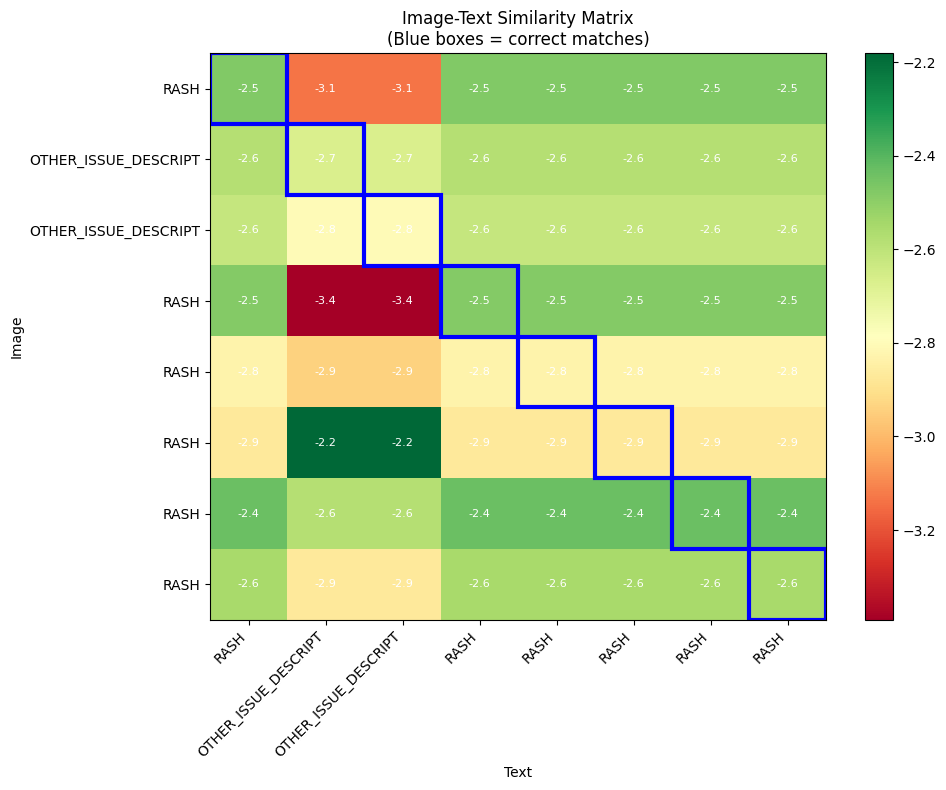


Batch Accuracy: 12.50%
Correct predictions: 1/8

Diagonal values (correct matches): [-2.474784  -2.6682606 -2.804411  -2.4819498 -2.8330746 -2.8689032
 -2.4317894 -2.553608 ]
Mean diagonal: -2.64
Mean off-diagonal: -2.66


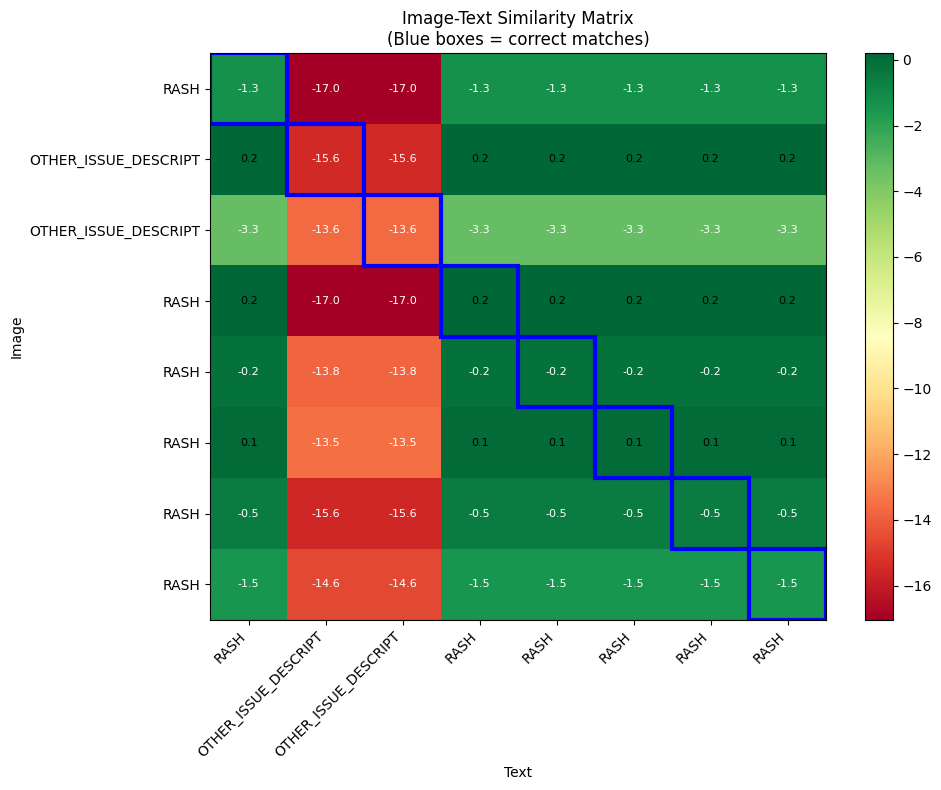


Batch Accuracy: 12.50%
Correct predictions: 1/8

Diagonal values (correct matches): [ -1.2780952  -15.563119   -13.647163     0.20522499  -0.16023064
   0.06907558  -0.5400181   -1.4572401 ]
Mean diagonal: -4.05
Mean off-diagonal: -4.41


In [70]:
# CELL: Understanding the Metrics for Contrastive Learning

"""
UNDERSTANDING THE METRICS
=========================

In contrastive learning with SigLIP, we're training the model so that:
- Each image should have highest similarity with its matching text
- Each text should have highest similarity with its matching image

For a batch of size N:
- We get an NxN similarity matrix (logits_per_image)
- The correct match for sample i is position i (diagonal elements)
- We predict which position has the highest similarity
- Accuracy = how often we predict the correct position

EXAMPLE:
--------
Batch of 16 images with their text descriptions:
- Image 0 with "melanoma" should match Text 0 "melanoma" (position 0)
- Image 1 with "nevus" should match Text 1 "nevus" (position 1)
- etc.

The model outputs a 16x16 similarity matrix. For each row i, we find argmax:
- If argmax(row_0) = 0  ✓ Correct! 
- If argmax(row_1) = 0  ✗ Wrong (should be 1)
- If argmax(row_2) = 2  ✓ Correct!

Accuracy = (number of correct predictions) / 16

INTERPRETING YOUR RESULTS:
--------------------------
Your debug showed:
  - Predicted labels (first 10): [0 0 0 0 0 0 0 0 0 0]
  - True labels (first 10): [0 1 2 3 4 5 6 7 8 9]
  - Accuracy: 0.0208 (2.08%)

This means:
⚠️ The model is predicting position 0 for almost everything!
⚠️ This is terrible performance (random would be ~6.25% for batch_size=16)

WHY IS THIS HAPPENING?
----------------------
1. The model hasn't been trained yet (baseline is untrained)
2. Or the model collapsed to predicting the same thing for everything
3. Only 2 training steps in debug mode (way too few!)

WHAT TO EXPECT AFTER TRAINING:
-------------------------------
- Baseline (untrained): 2-10% accuracy (random or worse)
- After training: 40-90% accuracy (depending on dataset difficulty)
- Well-trained: 70%+ accuracy

Good performance means:
✓ Accuracy increases significantly (20-30+ percentage points)
✓ Loss decreases
✓ The model learns to distinguish between different skin conditions
"""

def visualize_similarity_matrix(model, dataset, processor, device, num_samples=8):
    """
    Visualize the similarity matrix for a small batch.
    This helps understand what the model is learning.
    
    Args:
        model: Model to evaluate
        dataset: Dataset to sample from
        processor: Processor
        device: Device
        num_samples: Number of samples to visualize
    """
    import matplotlib.pyplot as plt
    
    # Get a batch
    samples = [dataset[i] for i in range(min(num_samples, len(dataset)))]
    inputs = collate_fn(samples, processor)
    
    if not inputs:
        print("Failed to create batch")
        return
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        similarity_matrix = outputs.logits_per_image.cpu().numpy()
    
    # Get labels
    labels = [s['text'][:20] for s in samples]  # Truncate for display
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(similarity_matrix, cmap='RdYlGn', aspect='auto')
    
    # Add colorbar
    plt.colorbar(im, ax=ax)
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    
    # Add values in cells
    for i in range(len(labels)):
        for j in range(len(labels)):
            color = 'white' if similarity_matrix[i, j] < 0 else 'black'
            text = ax.text(j, i, f'{similarity_matrix[i, j]:.1f}',
                          ha="center", va="center", color=color, fontsize=8)
    
    # Highlight diagonal
    for i in range(len(labels)):
        ax.add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, 
                                   fill=False, edgecolor='blue', lw=3))
    
    ax.set_title("Image-Text Similarity Matrix\n(Blue boxes = correct matches)")
    ax.set_xlabel("Text")
    ax.set_ylabel("Image")
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['OUTPUT_DIR'], 'similarity_matrix.png'))
    plt.show()
    
    # Print interpretation
    predictions = np.argmax(similarity_matrix, axis=1)
    correct = predictions == np.arange(len(predictions))
    accuracy = correct.sum() / len(correct)
    
    print(f"\nBatch Accuracy: {accuracy:.2%}")
    print(f"Correct predictions: {correct.sum()}/{len(correct)}")
    print(f"\nDiagonal values (correct matches): {np.diag(similarity_matrix)}")
    print(f"Mean diagonal: {np.diag(similarity_matrix).mean():.2f}")
    print(f"Mean off-diagonal: {similarity_matrix[~np.eye(len(labels), dtype=bool)].mean():.2f}")


print(__doc__)
print("\nVisualization function available:")
# Visualize the model AFTER fine-tuning
visualize_similarity_matrix(model_to_tune, val_dataset, processor, device)

# Visualize the model BEFORE fine-tuning
visualize_similarity_matrix(base_model, val_dataset, processor, device)


Visualization function available:


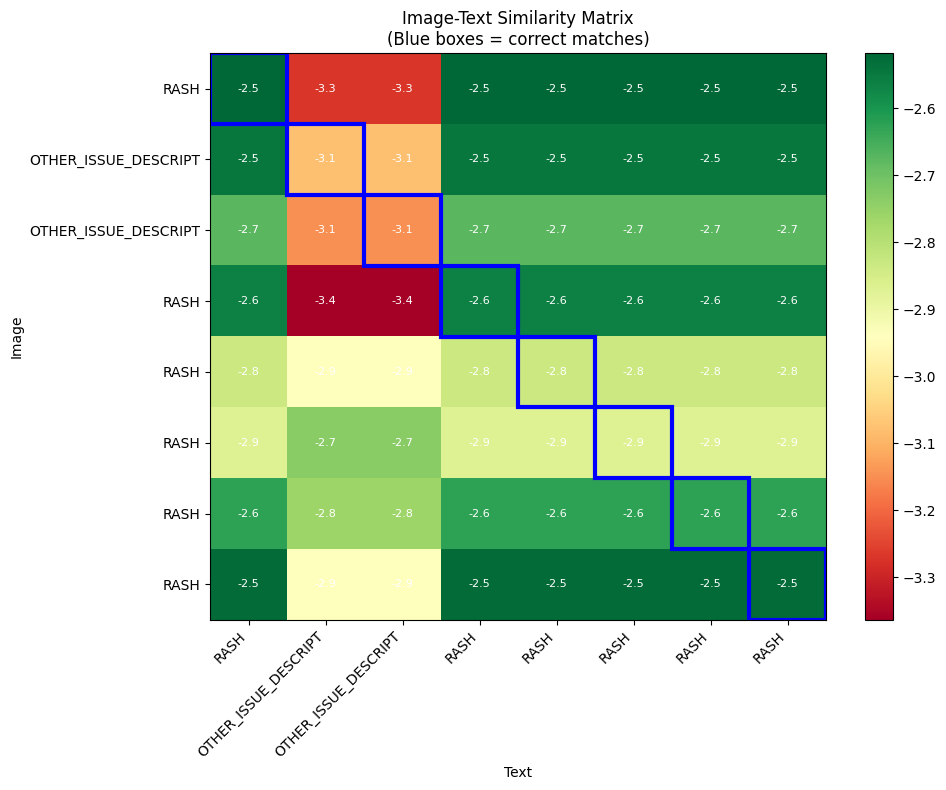


Batch Accuracy: 12.50%
Correct predictions: 1/8

Diagonal values (correct matches): [-2.5177794 -3.0767117 -3.1483698 -2.5607738 -2.8330746 -2.8689032
 -2.625266  -2.5249443]
Mean diagonal: -2.77
Mean off-diagonal: -2.74


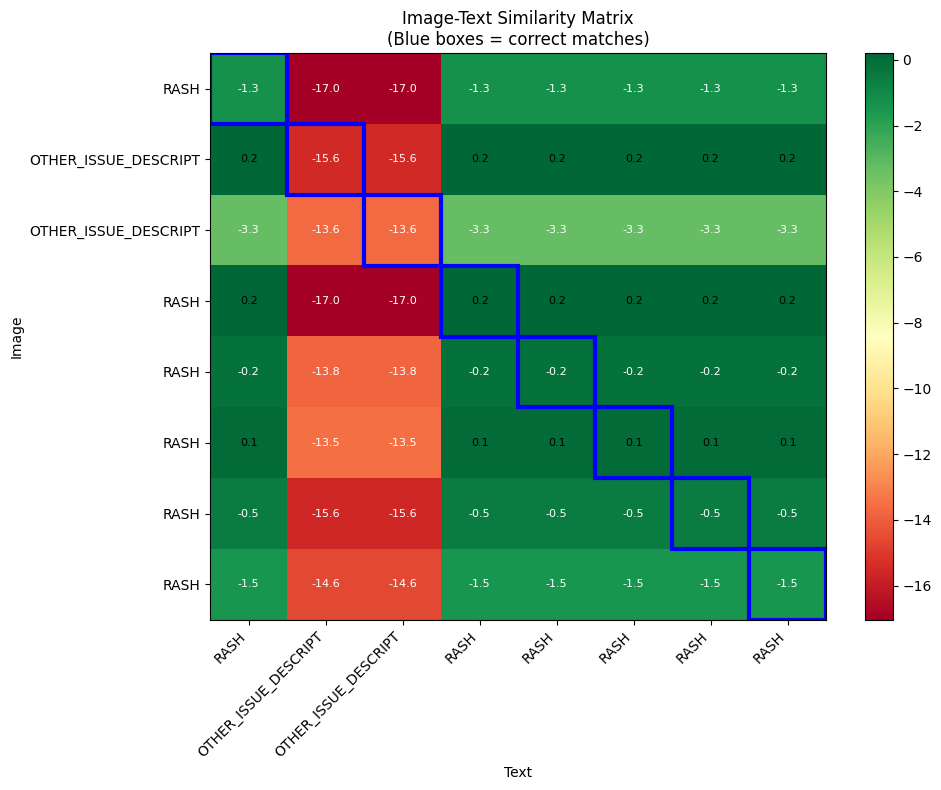


Batch Accuracy: 12.50%
Correct predictions: 1/8

Diagonal values (correct matches): [ -1.2780952  -15.563119   -13.647163     0.20522499  -0.16023064
   0.06907558  -0.5400181   -1.4572401 ]
Mean diagonal: -4.05
Mean off-diagonal: -4.41


In [84]:
print("\nVisualization function available:")
# Visualize the model AFTER fine-tuning
visualize_similarity_matrix(model_to_tune, val_dataset, processor, device)

# Visualize the model BEFORE fine-tuning
visualize_similarity_matrix(base_model, val_dataset, processor, device)